In [7]:
from TradingEnvironment import StockTrading as env
import pandas as pd

In [8]:
df = pd.read_csv('data/NIFTY50.csv')
my_env = env(df,5,(6,120))

Total Return: -45.83 % 			Total Reward: 1878.19


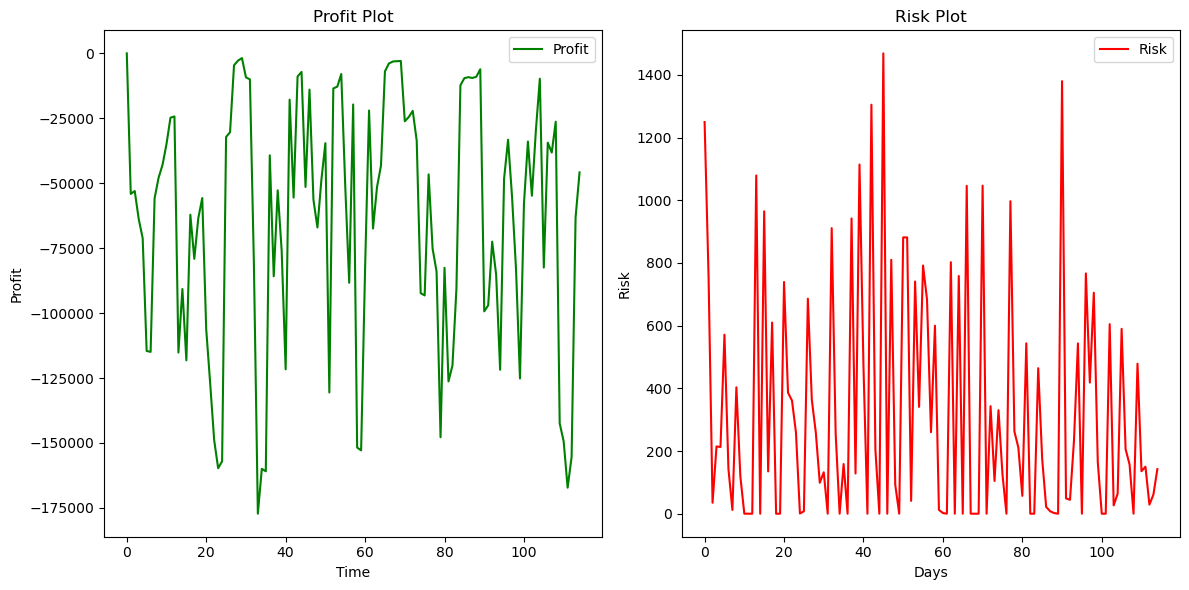

In [9]:
obs,_=my_env.reset(100000,0,0)
done=0
while not done:
    action=my_env.random_action()
    obs,reward,done,info=my_env.step(action)
    if done:
        print(f"Total Return: {my_env.percentageReturn()} %",f"\t\t\tTotal Reward: {info['Reward']}")
        my_env.render()